<a href="https://colab.research.google.com/github/alouwyck/dania-international-days/blob/main/artificial_intelligence/Intro_to_Artificial_Intelligence_demo_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

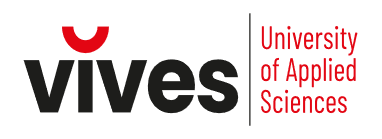<br>

**Dania International Days**<br>
13 - 15 March 2024<br><br>
Workshop by Dominique Stove & Andy Louwyck

---



---



# **INTRODUCTION TO ARTIFICIAL INTELLIGENCE WITH PYTHON**

## **Finding the Optimal Route**

The flight routes:

In [ ]:
routes = [["Brussels", "Paris"],
          ["Brussels", "Berlin"],
          ["Brussels", "Bern"],
          ["Paris", "Bern"],
          ["Berlin", "Budapest"],
          ["Berlin", "Bern"],
          ["Bern", "Rome"],
          ["Bern", "Belgrade"],
          ["Rome", "Athens"],
          ["Rome", "Belgrade"],
          ["Belgrade", "Bucharest"],
          ["Belgrade", "Athens"],
          ["Budapest", "Belgrade"],
          ["Budapest", "Bucharest"],
          ["Athens", "Istanbul"],
          ["Bucharest", "Istanbul"]]

Departure and destination:

In [ ]:
departure, destination = "Brussels", "Istanbul"

The cities:

In [ ]:
cities = {city for route in routes for city in route}
cities

Get geodataframe with cities:

In [ ]:
import geopandas  # library for spatial data
path_to_data = geopandas.datasets.get_path("naturalearth_cities")
gdf = geopandas.read_file(path_to_data)
gdf.head()

In [ ]:
# keep cities from flight routes
gdf = gdf[gdf.name.isin(cities)]
gdf

Function to calculate Euclidean distance between two cities:

In [ ]:
import geopy.distance

def distance(city1, city2):
    # city1 and city2 are shapely.geometry.point.Point objects
    lat1, lon1 = city1.y, city1.x
    lat2, lon2 = city2.y, city2.x
    return int(geopy.distance.geodesic((lat1, lon1), (lat2, lon2)).meters / 1000)  # distance in km

Creating the map:

In [ ]:
from matplotlib import pyplot as plt  # visualization library

# create figure and axes
_, ax = plt.subplots(1, 1);

# plot map
map = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
map.plot(color='lightblue', ax=ax);
map.boundary.plot(color='gray', ax=ax);

# plot cities
gdf.plot(color='black', ax=ax);
start = gdf[gdf.name==departure].geometry.iloc[0]
stop = gdf[gdf.name==destination].geometry.iloc[0]
plt.plot(start.x, start.y, 'go', stop.x, stop.y, 'ro');

# plot routes
for route in routes:
    city1 = gdf[gdf.name==route[0]].geometry.iloc[0]
    city2 = gdf[gdf.name==route[1]].geometry.iloc[0]
    plt.plot((city1.x, city2.x), (city1.y, city2.y), 'k-');

# zoom in on Europe
plt.xlim((-10, 40));
plt.ylim((35, 60));

Getting the coordinates:

In [ ]:
coordinates = {city[1]['name']: (city[1].geometry.x, city[1].geometry.y)
               for city in gdf[['name', 'geometry']].iterrows()}
coordinates

Convert the map into a graph:

In [ ]:
# defining the edges
edges = []
for route in routes:
    city1, city2 = route[0], route[1]
    dist = distance(gdf[gdf.name==city1].geometry.iloc[0],
                    gdf[gdf.name==city2].geometry.iloc[0])
    edges.append((city1, city2, dist))
edges

In [ ]:
# the nodes are the cities
# the heuristic value is the straight-line distance between a city and the destination

heuristic = {city: int(distance(gdf[gdf.name==city].geometry.iloc[0],
                                gdf[gdf.name==destination].geometry.iloc[0]))
             for city in cities}
heuristic

In [ ]:
import networkx as nx  # library for analyzing complex networks

G = nx.Graph()
for node, h in heuristic.items():
    G.add_node(node, h=h)
for edge in edges:
    G.add_edge(edge[0], edge[1], cost=edge[2])

Plotting the graph:

In [ ]:
labels = {node: node + "\n" + str(h) for node, h in nx.get_node_attributes(G, 'h').items()}  # h toevoegen aan de node labels
nx.draw(G, coordinates, labels=labels, node_size=750, node_color="y")
nx.draw_networkx_edge_labels(
    G, coordinates, nx.get_edge_attributes(G, 'cost')
);

Applying A*:

In [ ]:
from networkx.algorithms.shortest_paths import astar_path, astar_path_length

print('optimal route:', astar_path(G, source=departure, target=destination, weight="cost"))
print('total distance:', astar_path_length(G, source=departure, target=destination, weight="cost"))

## **Regression**

The dataset

In [ ]:
import pandas as pd
df = pd.read_csv('Student_Marks.csv')
df.head()  # show the first 5 records

In [ ]:
df.describe().T  # T transposes the resulting table

In [ ]:
import matplotlib.pyplot as plt
df.plot.scatter(x='time_study', y='Marks');
plt.grid();

Simple linear regression

In [ ]:
from sklearn.linear_model import LinearRegression

X, y = df[['time_study']].values, df.Marks.values  # feature X, target y

model = LinearRegression()  # instantiate class
model.fit(X, y)  # fit data
model.score(X, y)  # R² score

In [ ]:
import numpy as np  # numeric python library

df.plot.scatter(x='time_study', y='Marks');
xline = np.array([[0, 8]]).T  # must be 2D matrix!
yline = model.predict(xline)  # predict regression line
plt.plot(xline, yline, 'r-');
plt.grid();

Underfitting!

Polynomial regression

In [ ]:
import numpy as np
X = X.flatten()               # polyfit wants 1D array!
a = np.polyfit(X, y, deg=15)  # polynomial fit of degree 15

In [ ]:
from sklearn.metrics import r2_score  # import function to calculate R² score

yp = np.polyval(a, X)          # predictions
r2_score(y_true=y, y_pred=yp)  # R² score

In [ ]:
xcurve = np.linspace(0, 8, 100)  # create 100 equally spaced points x between 0 and 8
ycurve = np.polyval(a, xcurve)   # predict y for these 100 points x
df.plot.scatter(x='time_study', y='Marks')
plt.plot(xcurve, ycurve, 'r-');
plt.grid();

Overfitting!

Create validation set

In [ ]:
from sklearn.model_selection import train_test_split

X, y = df[['time_study']].values, df.Marks.values  # feature X, target y
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.4,      # 40% is used for validation
                                                  random_state=2024)  # set random seed

In [ ]:
plt.scatter(X_train.flatten(), y_train, color='blue', label='training set');
plt.scatter(X_val.flatten(), y_val, color='red', label='validation set');
plt.legend();
plt.xlabel('time_study');
plt.ylabel('Marks');
plt.grid();

In [ ]:
# linear regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
print(f"training: {linreg.score(X_train, y_train)}")
print(f"validation: {linreg.score(X_val, y_val)}")

In [ ]:
# polynomial regression (degree 15)
a = np.polyfit(X_train.flatten(), y_train, deg=15)  # polynomial fit of degree 15
print(f"training: {r2_score(y_true=y_train, y_pred=np.polyval(a, X_train.flatten()))}")
print(f"validation: {r2_score(y_true=y_val, y_pred=np.polyval(a, X_val.flatten()))}")

The model complexity graph

In [ ]:
from sklearn.metrics import mean_absolute_error as MAE  # import MAE function

mae_train = []  # list of MAEs of training data
mae_val = []    # list of MAEs of validation data
coef = []       # list of coefficients
degrees = range(1, 21)  # range of degrees of polynomial function

for degree in degrees:  # loop through degrees

    a = np.polyfit(X_train.flatten(), y_train, degree)  # polynomial fit of training data
    yp_train = np.polyval(a, X_train.flatten())         # predictions of training data
    yp_val = np.polyval(a, X_val.flatten())             # predictions of validation data

    coef.append(a)  # coefficients
    mae_train.append(MAE(y_true=y_train, y_pred=yp_train))  # MAE of training data
    mae_val.append(MAE(y_true=y_val, y_pred=yp_val))        # MAE of validation data

In [ ]:
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')

# initialization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # figure containing 2 axes
ax1.plot(X_train.flatten(), y_train, 'b.', label='training set');
ax1.plot(X_val.flatten(), y_val, 'r.', label='validation set');
ax1.legend();
xplot = np.linspace(0, 8, 1000)
regression_line = ax1.plot(xplot, np.polyval(coef[0], xplot),'k-')
ax1.set_title('degree = 1');
ax1.set_xlabel('time_study');
ax1.set_ylabel('Marks');
ax1.grid();
ax2.yaxis.set_label_position("right");
ax2.yaxis.tick_right();
mae_train_line = ax2.plot(degrees[0], mae_train[0], 'b.-', label='training');
mae_val_line = ax2.plot(degrees[0], mae_val[0], 'r.-', label='validation');
ax2.legend();
ax2.set_xlabel('Degree');
ax2.set_ylabel('MAE');
ax2.set_xlim((0, 21));
ax2.set_ylim((1, 5));
ax2.grid();

# update function for animation
def update(degree):
    yplot = np.polyval(coef[degree-1], xplot)
    regression_line[0].set_ydata(yplot)
    ax1.set_title('degree = ' + str(degree));
    mae_train_line[0].set_xdata(degrees[:degree])
    mae_train_line[0].set_ydata(mae_train[:degree])
    mae_val_line[0].set_xdata(degrees[:degree])
    mae_val_line[0].set_ydata(mae_val[:degree])

# create animation
ani = FuncAnimation(fig, update, frames=degrees, blit=False, repeat=True)
plt.close()
ani

In [ ]:
plt.plot(degrees, mae_train, 'b.-', label='training');
plt.plot(degrees, mae_val, 'r.-', label='validation');
plt.legend();
plt.xlabel('Degree');
plt.ylabel('MAE');
plt.grid();

In [ ]:
# polynomial fit degree 2

a = np.polyfit(X.flatten(), y, deg=2)
yp = np.polyval(a, X.flatten())
MAE(y_true=y, y_pred=yp)

In [ ]:
df.plot.scatter(x='time_study', y='Marks');
xplot = np.linspace(0, 8, 100)
plt.plot(xplot, np.polyval(a, xplot), 'r-');
plt.grid();

## **Image Classification**

The dataset

In [ ]:
from keras.datasets import mnist  # the MNIST dataset

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [ ]:
print(f"The training set constains {len(train_images)} images")
print(f"The test set contains {len(test_images)} images")

In [ ]:
import matplotlib.pyplot as plt

digit = train_images[4]  # 5th image (index 4!)
plt.imshow(digit, cmap=plt.cm.binary)  # plot image
plt.title(f"Label: {train_labels[4]}");  # label for 5th image

In [ ]:
type(digit)

In [ ]:
digit.shape

In [ ]:
digit.dtype

In [ ]:
digit.min(), digit.max()

In [ ]:
train_images = train_images.reshape((60000, 28 * 28))  # reshape
train_images = train_images.astype("float32") / 255  # normalize and convert to float
test_images = test_images.reshape((10000, 28 * 28))  # reshape
test_images = test_images.astype("float32") / 255  # normalize and convert to float

Our own hand-written digit

In [ ]:
# own hand written digit
import PIL
import numpy as np
digit = PIL.Image.open("digit.png")  # read image
digit = digit.resize((28, 28))  # resize image to 28 x 28
digit = digit.convert('L')  # convert image to black and white (L = luminance)
digit = np.array(digit)  # convert image to numpy array
digit = 255 - digit  # turn black into whihte and white in to black
digit = digit.astype("float32") / 255.0  # normalize array
plt.imshow(digit, cmap=plt.cm.binary);  # plot digit

A fully connected network

In [ ]:
# a fully connected neural net

from tensorflow import keras

model = keras.Sequential([
 keras.layers.Dense(512, activation="relu"),  # hidden layer consisting of 512 neurons and relu as activation
 keras.layers.Dense(10, activation="softmax")  # output layer consisting of 10 neurons and softmax as activation
])

model.build(input_shape=(None, 28 * 28))  # number of neurons for the input layer
model.summary()

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",  # loss function that calculates difference between predicted and true labels
    optimizer="rmsprop",  # algorithm that minimizes the loss function
    metrics=["accuracy"]  # calculate accuracy after each iteration (epoch)
  )

In [ ]:
# training the model using the training set
model.fit(train_images, train_labels,
          epochs=5,
          batch_size=128);

Evaluating the model

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)  # evaluate model using the test set
print(f"accuracy on the test set: {test_acc}")

Our own digit

In [ ]:
probs = model.predict(digit.reshape(1, -1))  # predict returns 10 probabilities
probs[0]

In [ ]:
prob = np.max(probs) * 100  # largest probability
n = np.argmax(probs)  # index (= digit) corresponding to the largest probability
print(f"The neural network is for {prob:.2f} % sure the digit is {n}!")

Convolutional network

In [ ]:
# convolutional neural net

model = keras.Sequential([
  keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
  keras.layers.MaxPooling2D(pool_size=2),
  keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu"),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation="softmax")  # output layer consisting of 10 neurons and softmax as activation
])

model.build(input_shape=(None, 28, 28, 1))  # input consists of images of 28 x 28 pixels en 1 color channel
model.summary()

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",  # loss function
    optimizer="rmsprop",  # optimizer
    metrics=["accuracy"]  # accuracy as metric
  )

In [ ]:
# a convnet processes images!

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

In [ ]:
model.fit(train_images, train_labels, epochs=5, batch_size=64);

Evaluating the model

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"accuracy on the test set: {test_acc}")

Our own digit

In [ ]:
probs = model.predict(digit[np.newaxis, :, :])  # add extra dimension!
prob = np.max(probs) * 100
n = np.argmax(probs)
print(f"The convnet is for {prob:.2f} % sure that the digit is {n}!")